# softmax实现练习
 在本章练习中我们将逐步完成：
* 1.熟悉使用CIFAR-10 数据集
* 2.编码softmax_loss_naive函数 使用显式循环计算损失函数以及梯度
* 3.编码softmax_loss_vectorized函数  使用向量化表达计算损失函数以及梯度
* 4.编码最小批量梯度下降算法 训练softmax分类器
* 5.使用验证数据选择超参数

In [1]:
#-*- coding: utf-8 -*-
import random
import numpy as np
from utils.data_utils import load_CIFAR10
from classifiers.chapter2 import *
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
%load_ext autoreload
%autoreload 2

In [2]:
# 导入 CIFAR-10 数据.
cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 查看数据
print '训练数据（数据个数，数据维度）: ', X_train.shape
print '训练数据标记（数据标记个数，）: ', y_train.shape
print '测试数据（数据个数，数据维度）: ', X_test.shape
print '测试数据标记（数据标记个数，）: ', y_test.shape

训练数据（数据个数，数据维度）:  (50000L, 32L, 32L, 3L)
训练数据标记（数据标记个数，）:  (50000L,)
测试数据（数据个数，数据维度）:  (10000L, 32L, 32L, 3L)
测试数据标记（数据标记个数，）:  (10000L,)


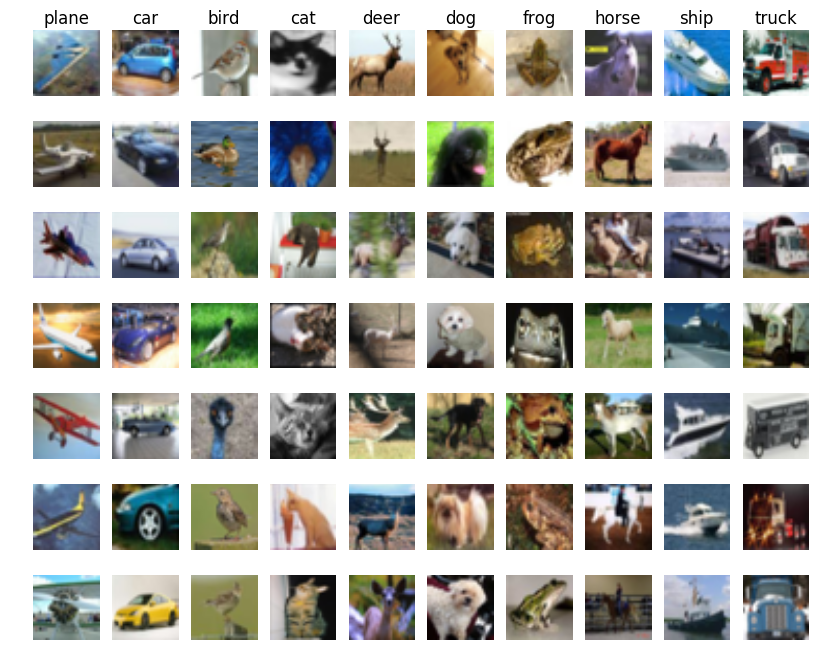

In [3]:
# 数据可视化.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## 1.数据预处理
在通常情况下，我们需要对输入数据进行归一化处理，也就是使得数据呈均值为零，方差为1的标准正态分布。由于图像的特征范围在[0,255]，其方差已经被约束了，我们只需要将数据进行零均值中心化处理即可，不需要将数据压缩在[-1,1]范围(当然，你也可以进行此项处理)。

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=100, num_test=10000, num_sample=250):
  # 导入 CIFAR-10 data
  cifar10_dir = 'datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # 采样数据
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_sample, replace=False)
  X_sample = X_train[mask]
  y_sample = y_train[mask]
  
  # 将数据重塑成（数据个数，维度）形状
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_sample = np.reshape(X_sample, (X_sample.shape[0], -1))
  
  # 数据预处理，减去其均值
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_sample -= mean_image
  
  #在每列数据中加入偏置项
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_sample = np.hstack([X_sample, np.ones((X_sample.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_sample, y_sample

X_train, y_train, X_val, y_val, X_test, y_test, X_sample, y_sample = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'sample data shape: ', X_sample.shape
print 'sample labels shape: ', y_sample.shape

Train data shape:  (49000L, 3073L)
Train labels shape:  (49000L,)
Validation data shape:  (100L, 3073L)
Validation labels shape:  (100L,)
Test data shape:  (10000L, 3073L)
Test labels shape:  (10000L,)
sample data shape:  (250L, 3073L)
sample labels shape:  (250L,)


## 2.使用显式循环计算损失函数以及梯度

In [ ]:
#首先我们将用循环的方式实现softmax的损失函数（代价函数）
#打开 classifiers/chapter2/softmax_loss.py 文件并实现softmax_loss_naive函数
#完成之后运行该单元代码
from classifiers.chapter2.softmax_loss import softmax_loss_naive
import time

# 初始化权重
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_sample, y_sample, 0.0)

# 你的初始化损失值应该接近于 -log(0.1).
print '你实现的softmax损失值loss: %f' % loss
print '正确的损失值: %f' % ( -np.log(0.1) )

In [ ]:
# 使用数值梯度检验你已实现的softmax_loss_naive
# 你实现的梯度应该要接近于数值梯度
from utils.gradient_check import grad_check_sparse
loss, grad = softmax_loss_naive(W, X_sample, y_sample, 0.0)

print '检验无权重衰减的softmax_loss_naive梯度：'
f = lambda w: softmax_loss_naive(w, X_sample, y_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print '检验加入权重衰减项后的softmax_loss_naive梯度：'
loss, grad = softmax_loss_naive(W, X_sample, y_sample, 1e2)
f = lambda w: softmax_loss_naive(w, X_sample, y_sample, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

## 3. 使用向量化表达计算损失函数以及梯度

In [ ]:
# 现在我们将实现向量化的softmax损失及其梯度计算
# 打开softmax_loss_vectorized函数并完成相应任务，运行该段代码
# 向量化版本应该和显式循环版本相同，但前者的计算效率应该快速得很多
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_sample, y_sample, 0.00001)
toc = time.time()
print '显式循环版loss: %e   花费时间 %fs' % (loss_naive, toc - tic)

from classifiers.chapter2.softmax_loss import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_sample, y_sample, 0.00001)
toc = time.time()
print '向量化版本 loss: %e    花费时间 %fs' % (loss_vectorized, toc - tic)

# 比较结果
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print '损失误差: %f' % np.abs(loss_naive - loss_vectorized)
print '梯度误差: %f' % grad_difference

## 4.最小批量梯度下降算法 训练softmax分类器

In [ ]:
# 打开softmax.trian()完成随机梯度下降任务，然后执行该段代码
from classifiers.chapter2.softmax import *
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_sample, y_sample, learning_rate=1e-7, reg=5e4,
                      num_iters=3500, verbose=True)
toc = time.time()
print '花费时间 %fs' % (toc - tic)

In [ ]:
# 查看损失值的变化情况
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# 测试训练集，验证集的精度
y_train_pred = softmax.predict(X_sample)
print y_train_pred.shape
print '训练数据量：%f    训练正确率: %f' % (X_sample.shape[0],np.mean(y_sample == y_train_pred), )
y_val_pred = softmax.predict(X_val)
print '验证数据量：%f    验证正确率: %f' % (X_val.shape[0],np.mean(y_val == y_val_pred), )

## 5.使用验证数据选择超参数

In [ ]:
#使用验证集调整超参数(权重衰减因子，学习率)
from classifiers.chapter2.softmax import *
results = {}
best_val = -1
best_l = 0
best_r = 0
best_softmax = None
learning_rates=np.logspace(-9, 0, num=10)
regularization_strengths=np.logspace(0, 5, num=10)
batch_size = [50]
num_iters  = [300]

for b in batch_size:
    for n in num_iters:
        for l in learning_rates:
            for r in regularization_strengths:
                 softmax = Softmax()
                 loss_hist = softmax.train(X_sample, y_sample, 
                                           learning_rate=l,reg=r,
                                           num_iters=n,
                                           batch_size=b,
                                           verbose=False)
                 y_train_pred = softmax.predict(X_sample)
                 train_accuracy= np.mean(y_sample == y_train_pred)
                 y_val_pred = softmax.predict(X_val)
                 val_accuracy= np.mean(y_val == y_val_pred)
                 results[(l,r)]=(train_accuracy,val_accuracy)
                 if (best_val < val_accuracy):
                    best_val = val_accuracy
                    best_softmax = softmax
                    best_l =l
                    best_r =r
    
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e 训练精度: %f 验证精度: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print '最佳学习率为：%e 最佳权重衰减系数为：%e 其所对应的验证精度为: %f' % (best_l,best_r,best_val)

In [ ]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# 绘制训练数据精度
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

#绘制验证数据精度
colors = [results[x][1] for x in results] 
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
#使用验证集调整超参数(权重衰减因子，学习率)
from classifiers.chapter2.softmax import *
results = {}
best_val = -1
best_l = 0
best_r = 0
best_softmax = None
learning_rates=np.logspace(-6, -4, num=10)
regularization_strengths=np.logspace(-1, 4, num=5)
batch_size = [50]
num_iters  = [300]

for b in batch_size:
    for n in num_iters:
        for l in learning_rates:
            for r in regularization_strengths:
                 softmax = Softmax()
                 loss_hist = softmax.train(X_sample, y_sample,
                                           learning_rate=l, reg=r,
                                           num_iters=n,batch_size=b, verbose=False)
                 y_train_pred = softmax.predict(X_sample)
                 train_accuracy= np.mean(y_sample == y_train_pred)
                 y_val_pred = softmax.predict(X_val)
                 val_accuracy= np.mean(y_val == y_val_pred)
                 results[(l,r)]=(train_accuracy,val_accuracy)
                 if (best_val < val_accuracy):
                    best_val = val_accuracy
                    best_softmax = softmax
                    best_l =l
                    best_r =r

    
print '最佳学习率为：%e 最佳权重衰减系数为：%e 其所对应的验证精度为: %f' % (best_l,best_r,best_val)

In [ ]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]


# 绘制训练数据精度
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

#绘制验证数据精度
colors = [results[x][1] for x in results] 
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
#使用验证集调整超参数(权重衰减因子，学习率)
from classifiers.chapter2.softmax import *
results = {}
best_val = -1
best_l = 0
best_r = 0
best_softmax = None
learning_rates=np.logspace(-5, -4, num=10)
regularization_strengths=np.logspace(-2, 3, num=5)
batch_size = [50]
num_iters  = [300]

for b in batch_size:
    for n in num_iters:
        for l in learning_rates:
            for r in regularization_strengths:
                 softmax = Softmax()
                 loss_hist = softmax.train(X_sample, y_sample, learning_rate=l,
                                           reg=r,num_iters=n,batch_size=b, verbose=False)
                 y_train_pred = softmax.predict(X_sample)
                 train_accuracy= np.mean(y_sample == y_train_pred)
                 y_val_pred = softmax.predict(X_val)
                 val_accuracy= np.mean(y_val == y_val_pred)
                 results[(l,r)]=(train_accuracy,val_accuracy)
                 if (best_val < val_accuracy):
                    best_val = val_accuracy
                    best_softmax = softmax
                    best_l =l
                    best_r =r

    
print '最佳学习率为：%e 最佳权重衰减系数为：%e 其所对应的验证精度为: %f' % (best_l,best_r,best_val)

In [ ]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')


colors = [results[x][1] for x in results] 
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
#在测试数据集上评估最佳softmax分类器
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print '测试集精度: %f' % test_accuracy

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
  cifar10_dir = 'datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir) 
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]  
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))  
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 
  return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

In [ ]:
from classifiers.chapter2.softmax  import Softmax
results = {}
best_val = -1
best_softmax = None
################################################################################
#                            任务:                                             #
#               使用全部训练数据训练一个最佳softmax                            #
################################################################################
learning_rates = [1.4e-7, 1.45e-7, 1.5e-7, 1.55e-7, 1.6e-7]
regularization_strengths = [2.3e4, 2.6e4, 2.7e4, 2.8e4, 2.9e4]
for l in learning_rates:
    for r in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=l, 
                                  reg=r,num_iters=2000, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_accuracy= np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy= np.mean(y_val == y_val_pred)
        results[(l,r)]=(train_accuracy,val_accuracy)
        if (best_val < val_accuracy):
            best_val = val_accuracy
            best_softmax = softmax
################################################################################
#                            结束编码                                          #
################################################################################

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print '最佳验证精度为: %f' % best_val

In [ ]:
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print '测试集精度: %f' % test_accuracy

In [ ]:
# 可视化学习到的参数
w = best_softmax.W[:-1,:] # 移除偏置项
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  #将权重缩放回0-255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])